<picture>
  <source media="(prefers-color-scheme: dark)" srcset="https://assets.vespa.ai/logos/Vespa-logo-green-RGB.svg">
  <source media="(prefers-color-scheme: light)" srcset="https://assets.vespa.ai/logos/Vespa-logo-dark-RGB.svg">
  <img alt="#Vespa" width="200" src="https://assets.vespa.ai/logos/Vespa-logo-dark-RGB.svg" style="margin-bottom: 25px;">
</picture>

# Optimizing ANN strategy for your Vespa application

<div class="alert alert-info">
    You probably want to be somewhat familiar with Vespa and ANN search before going through this example.<br>Recommended background reading: 
    <ul>
        <li><a href="https://docs.vespa.ai/en/nearest-neighbor-search-guide.html">Vespa nearest neighbor search - a practical guide</a></li>
        <li><a href="https://blog.vespa.ai/approximate-nearest-neighbor-search-in-vespa-part-1/">ANN Search in Vespa</a></li>
        <li><a href="https://blog.vespa.ai/constrained-approximate-nearest-neighbor-search/">Query Time Constrained Approximate Nearest Neighbor Search</a></li>
        <li><a href="https://blog.vespa.ai/additions-to-hnsw/">Additions to HNSW in Vespa: ACORN-1 and Adaptive Beam Search</a></li>
        <li><a href="https://blog.vespa.ai/tweaking-ann-parameters/">A Short Guide to Tweaking Vespa's ANN Parameters</a></li>
    </ul>
</div>    

Approximate Nearest Neighbor (ANN) search is a powerful way to make vector search scalable and efficient. In Vespa, this is implemented by building HNSW graphs for embedding fields.

## Why different strategies are needed

For a search that uses _only_ vector similarity for retrieval, this works very well for all cases, as you can just query the HNSW index and get (enough) relevant results back very fast.

However, most Vespa applications are more complex, and implement some sort of hybrid retrieval strategy, often combining vector similarity with filtering on metadata fields and/or lexical matching (weakAnd).

In this case, it is not obvious whether applying the filter first and doing an exact search will be more efficient than doing HNSW (in different variations, as we will get back to). 

The _hit-ratio_ of the filter for a given query will determine what is the most efficient strategy for the given query. 

The part that complicates this further is that the tipping point for which a strategy should be chosen is not uniform across Vespa applications, and must be tuned individually. 

This notebook will demonstrate how this tuning can be done with the recent addition of the `VespaNNParameterOptimizer` class. 

Hopefully, by stepping through this notebook, you will have learned how you can apply the same steps to tune _your_ Vespa application (configuration parameters) to get fast search responses while still maintaining acceptable recall. 

## A short note on `recall`

It is worth noting that our definition of `recall` in the context of tuning NN-parameters differs slightly from the `recall` definition used in eg. `VespaMatchEvaluator`.

When optimizing NN-parameters, the recall will be the fraction of top K (targetHits) documents scored by exact distance that are also retrieved by the given strategy. 

This approach does not need a set of `relevant_docs`,in contrast to the `VespaMatchEvaluator`, which calculates the recall as fraction of relevant documents that are retrieved.

The good news is that a set of representative queries is all we need to tune these parameters to find the values that ensures a fast response time _and_ maintains acceptable recall across your provided queries. 

## The different strategies

With the recent addition of ACORN-1 and Adaptive Beam Search to Vespa's ANN implementation, Vespa now switches between one of the following three strategies:

1. HNSW Search with Pre-Filtering when the percentage of filtered-out documents is low,
2. HNSW Search with Pre-Filtering: Filter First/ACORN-1 when the percentage of filtered-out documents is high,
3. Exact Nearest-Neighbor Search when the percentage of filtered-out documents approaches 100%.

<img alt="#Vespa" src="https://blog.vespa.ai/assets/2025-09-04-tweaking-ann-parameters/default.svg" style="margin-bottom: 25px;">

_When_ to switch between these three strategies is determined by a combination of a per-query internally calculated `hit-ratio`, which first is _estimated_ from a subset of the data, and later may be calculated _exactly_ (if pre-filter execution is applied) and the parameters below:

- [approximate-threshold](): If _estimated_ hit ratio for a filter is _less_ than this value, exact search is chosen. (Default value is `0.05`).
- [filter-first-threshold](): If _exact_ hit ratio for a filter is _less than_ this value, the ACORN-1 strategy is chosen. If it is _larger than or equal to_ this value, regular HNSW with pre-filtering is chosen. (Default value is `0.00`, meaning ACORN-1 is _disabled_).

These parameters can be configured per [rank profile](TODO) or provided as a [query parameter] which is passed with the query.

Now, let us get started with the practical part. 

## The dataset

The dataset we will use for this notebook is a subset of the [GIST1M-dataset](http://corpus-texmex.irisa.fr/) commonly used for ANN benchmarks.

We have also enriched each document with a `filter`-field of type `array<int>`, that is added to each document, which allows us to construct queries with a predictable hit ratio.

Here is an example document:

```json
{
  "put": "id:test:test::499",
  "fields": {
    "id": 499,
    "filter": [1,10,50,90,95,99],
    "vec_m16": { "values": [0.01345, .., 0.30322] } // 960 float values 
  }
}
```

99% of the documents include the value 1 in the filter field, 90% of the documents include the value 10 in the fitler field and so on.

## Downloading the dataset

In [ ]:
import os
import pathlib
import requests
import matplotlib.pyplot as plt
from vespa.io import VespaResponse

data_base_url = (
    "https://data.vespa-cloud.com/tests/performance/nearest-neighbor/gist-data/"
)

# We use a smaller dataset if the SCALE_DOWN flag is set to True
SCALE_DOWN = True
docs_url = (
    data_base_url + "docs.1k.json" if SCALE_DOWN else data_base_url + "docs.300k.json"
)
query_url = (
    data_base_url + "query_vectors.10.txt"
    if SCALE_DOWN
    else data_base_url + "query_vectors.100.txt"
)

In [ ]:
def download_file(url: str, dest_folder: str):
    local_filename = os.path.join(dest_folder, url.split("/")[-1])
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    return local_filename


data_path = "ann_test/"
pathlib.Path(data_path).mkdir(parents=True, exist_ok=True)
docs_path = download_file(docs_url, data_path)
query_path = download_file(query_url, data_path)

## Defining the Vespa application

In [ ]:
from vespa.package import (
    ApplicationPackage,
    Schema,
    Document,
    Field,
    RankProfile,
    HNSW,
    DocumentSummary,
    Summary,
)
from vespa.configuration.query_profiles import query_profile, query_profile_type, field


# Define the document with fields
doc = Document(
    fields=[
        Field(
            name="id",
            type="int",
            indexing=["attribute", "summary"],
        ),
        Field(
            name="filter",
            type="array<int>",  # This is our filter field
            indexing=["attribute", "summary"],
            attribute=["fast-search"],
        ),
        Field(
            name="vec_m16",
            type="tensor<float>(x[960])",  # The vector field that we will do ANN search on
            indexing=["attribute", "index", "summary"],
            ann=HNSW(
                distance_metric="euclidean",  # specific to this dataset
                max_links_per_node=16,  #
                neighbors_to_explore_at_insert=500,  # Specifies how many neighbors to explore when inserting a vector in the HNSW graph. The default value in Vespa is 200. This parameter is called efConstruction in the HNSW paper.
            ),
        ),
    ]
)

# Define the rank profile with HNSW tuning parameters
rank_profile = RankProfile(
    name="default",
    inputs=[
        ("query(q_vec)", "tensor<float>(x[960])"),
    ],
    first_phase="closeness(label,nns)",
    # We will tune some of these by overriding them as query parameters later
    rank_properties=[
        ("approximate-threshold", 0.05),
        ("filter-first-threshold", 0.0),
        ("filter-first-exploration", 0.3),
        ("exploration-slack", 0.0),
    ],
)

# Define a minimal document summary to avoid unnecessary data transfer
minimal_summary = DocumentSummary(name="minimal", summary_fields=[Summary(name="id")])

# Create the schema
schema = Schema(
    name="test",
    document=doc,
    rank_profiles=[rank_profile],
    document_summaries=[minimal_summary],
)

# We also define a query profile type for the default query profile to enforce the type of the input tensor
# See https://docs.vespa.ai/en/query-profiles.html#query-profile-types
qp = query_profile(
    id="default",
    type="root",
)

qpt = query_profile_type(
    field(
        name="ranking.features.query(q_vec)",
        type="tensor<float>(x[960])",
    ),
    id="root",
    inherits="native",
)

# Create the application package
app_package = ApplicationPackage(
    name="test", schema=[schema], query_profile_config=[qp, qpt]
)

<query-profile-type id="root" inherits="native">
  <field name="ranking.features.query(q_vec)" type="tensor&lt;float&gt;(x[960])" />
</query-profile-type>

<query-profile id="default" type="root" />

It is often useful to dump the application package to files for inspection before deploying. 

In [4]:
app_package.to_files("ann_test")

In [ ]:
from vespa.deployment import VespaDocker
from vespa.application import Vespa

vespa_docker = VespaDocker()
app: Vespa = vespa_docker.deploy(app_package)

## Feeding the documents

In [ ]:
# Load and feed documents
import json

with open(docs_path, "r") as f:
    docs = json.load(f)

docs_formatted = [
    {
        "id": str(doc["fields"]["id"]),
        "fields": doc["fields"],
    }
    for doc in docs
]

In [8]:
print(len(docs_formatted))

1000


In [9]:
def callback(response: VespaResponse, id: str):
    if not response.is_successful():
        print("Id " + id + " + failed : " + response.json)


app.feed_iterable(docs_formatted)

## Constructing queries

We will use the [Querybuilder API](/query.html#using-the-querybuilder-dsl-api) to construct our queries.

In [ ]:
import vespa.querybuilder as qb


def vector_to_query(vec_str: str, filter_value: int) -> dict:
    return {
        "yql": str(
            qb.select("*")
            .from_("test")
            .where(
                qb.nearestNeighbor(
                    "vec_m16",
                    "q_vec",
                    annotations={
                        "targetHits": 100,
                        "approximate": True,
                        "label": "nns",
                    },
                )
                & (qb.QueryField("filter") == filter_value),
            )
        ),
        "hits": 10,
        "presentation.summary": "minimal",
        "timeout": "20s",
        "ranking.features.query(q_vec)": vec_str.strip(),
    }

In [ ]:
with open(query_path, "r") as f:
    query_vectors = f.readlines()

# Filter values
filter_percentage = [1, 10, 50, 90, 95, 99]

# We will construct queries for each combination of query vector and filter value
queries = []
# We will also construct a single query per filter value for hit ratio evaluation
# The vector does not affect the hit ratio, so it is overkill to run a query for each vector
# just to determine the hit ratio
hitratio_queries = []  # will only have one query per filter value, choosing the last vector arbitrarily
for filter_value in filter_percentage:
    for vec in query_vectors:
        queries.append(vector_to_query(vec, filter_value))
    hitratio_queries.append(queries[-1])
print(len(queries), len(hitratio_queries))

60 6


Let us now run a test query against our Vespa app.

In [ ]:
resp = app.query(queries[0])
resp.json

{'root': {'id': 'toplevel',
  'relevance': 1.0,
  'fields': {'totalCount': 100},
  'coverage': {'coverage': 100,
   'documents': 300000,
   'full': True,
   'nodes': 1,
   'results': 1,
   'resultsFull': 1},
  'children': [{'id': 'index:test_content/0/682a71f8ae36aa46bc281d2b',
    'relevance': 0.6098925218782794,
    'source': 'test_content',
    'fields': {'sddocname': 'test', 'id': 242301}},
   {'id': 'index:test_content/0/95a20e5b3acd04270cfeca29',
    'relevance': 0.5855330073211734,
    'source': 'test_content',
    'fields': {'sddocname': 'test', 'id': 199090}},
   {'id': 'index:test_content/0/e3cdf54546668835b04dc624',
    'relevance': 0.5840317995027087,
    'source': 'test_content',
    'fields': {'sddocname': 'test', 'id': 161401}},
   {'id': 'index:test_content/0/394967b5ace9db9f57bdcd7e',
    'relevance': 0.5779684515745679,
    'source': 'test_content',
    'fields': {'sddocname': 'test', 'id': 99363}},
   {'id': 'index:test_content/0/48e6328a980adf028aa4262e',
    'relev

## Parameter Optimization

Now we'll optimize the HNSW parameters for our queries. This process will:
1. Determine hit ratios for queries
2. Optimize `filterFirstExploration` by collecting resp
3. Optimize `filterFirstThreshold`
4. Optimize `approximateThreshold`
5. Optimize `postFilterThreshold`
6. Compare current vs suggested settings

When constructing your own query set for tuning these values, you should make sure that the queries are representative for _your_ query load. As this might be difficult to predict in advance, it might also be wise to ensure that you have some queries with filters that have both large and small hit ratios, to ensure that also these type of queries would perform well with your application. 

### Step 1: Determine Hit Ratios

You might question why we want to find out the hit ratios, as we previously stated that we knew them. 

Consider the more common case where you do not know the hit ratio in advance, and you see that this is a necessary prerequisite step in order to tune your parameters.

In [61]:
from vespa.evaluation import VespaNNGlobalFilterHitratioEvaluator
from vespa.evaluation import VespaNNParameterOptimizer

hitratio_evaluator = VespaNNGlobalFilterHitratioEvaluator(queries, app)
hitratios = hitratio_evaluator.run()
hitratios[:3]

[[0.9899967000109999], [0.9899967000109999], [0.9899967000109999]]

As you can see, the hitratios returned is a list of hitratio(s) per query. This is due to the fact that a Vespa query can contain several `nearestNeighbor` elements. (For instance over two different fields).
Let us inspect the hit ratios for the queries:

Let us first unpack the hitratios list, to get an array of floats. 

In [64]:
hitratios = [hr[0] for hr in hitratios]
hitratios[:3]

[0.9899967000109999, 0.9899967000109999, 0.9899967000109999]

In [65]:
hitratios_yql = [
    {"yql": q["yql"], "hitratio": hitratio} for q, hitratio in zip(queries, hitratios)
]
# Only show one entry per query vector, as hitratio for all queries with same filter value will be identical
hitratios_yql[:: len(query_vectors)]

[{'yql': 'select * from test where ({targetHits:100,approximate:true,label:"nns"}nearestNeighbor(vec_m16, q_vec)) and filter = 1',
  'hitratio': 0.9899967000109999},
 {'yql': 'select * from test where ({targetHits:100,approximate:true,label:"nns"}nearestNeighbor(vec_m16, q_vec)) and filter = 10',
  'hitratio': 0.8999970000099999},
 {'yql': 'select * from test where ({targetHits:100,approximate:true,label:"nns"}nearestNeighbor(vec_m16, q_vec)) and filter = 50',
  'hitratio': 0.4999983333388889},
 {'yql': 'select * from test where ({targetHits:100,approximate:true,label:"nns"}nearestNeighbor(vec_m16, q_vec)) and filter = 90',
  'hitratio': 0.09999966666777778},
 {'yql': 'select * from test where ({targetHits:100,approximate:true,label:"nns"}nearestNeighbor(vec_m16, q_vec)) and filter = 95',
  'hitratio': 0.04999983333388889},
 {'yql': 'select * from test where ({targetHits:100,approximate:true,label:"nns"}nearestNeighbor(vec_m16, q_vec)) and filter = 99',
  'hitratio': 0.0099999666667777

And we can see the corresponding hit ratios for each of the filter values. 

They match what we expected.

The next step is to distribute the queries into buckets based on their hitratios. Note that this must be done for

In [68]:
# Sort hit ratios into buckets
optimizer = VespaNNParameterOptimizer(app, 100, print_progress=True)
optimizer.distribute_to_buckets(zip(queries, hitratios))

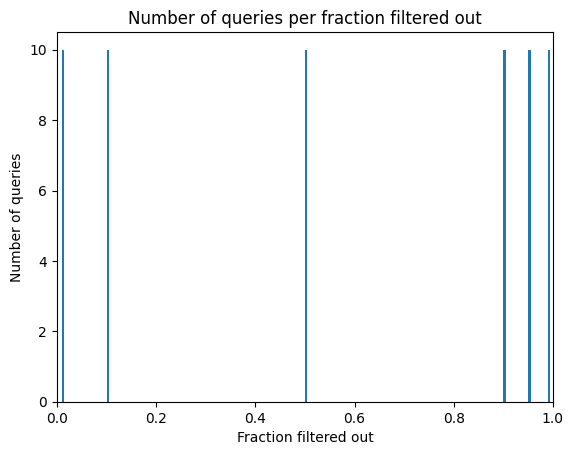

In [69]:
# Plot query distribution
x, y = optimizer.get_query_distribution()
plt.bar(x, y, width=optimizer.get_bucket_interval_width(), align="edge")
plt.title("Number of queries per fraction filtered out")
plt.xlabel("Fraction filtered out")
plt.ylabel("Number of queries")
axs = plt.gca()
axs.set_xlim(xmin=0, xmax=1)
axs.set_ylim(ymin=0)
plt.show()

### Step 2: Optimize filterFirstExploration

This parameter controls how much exploration to do when using the filter-first strategy.
The `suggest_filter_first_exploration()`-method samples response times and calculates recall for a range of different values, and suggests a value that does not cause significant increase in response time (compared to plain HNSW), and does not result in signifant reduction in recall. 

In [70]:
print("Determining suggestion for filterFirstExploration")
filter_first_exploration, benchmarks = optimizer.suggest_filter_first_exploration()
print(f"  filterFirstExploration: {round(filter_first_exploration, 3)}")

Determining suggestion for filterFirstExploration
  Benchmarking: 100.0%
  Computing recall: 100.0%
  Benchmarking: 100.0%
  Computing recall: 100.0%
  Testing 0.5
  Benchmarking: 100.0%
  Computing recall: 100.0%
  Testing 0.25
  Benchmarking: 100.0%
  Computing recall: 100.0%
  Testing 0.375
  Benchmarking: 100.0%
  Computing recall: 100.0%
  Testing 0.4375
  Benchmarking: 100.0%
  Computing recall: 100.0%
  Testing 0.40625
  Benchmarking: 100.0%
  Computing recall: 100.0%
  Testing 0.421875
  Benchmarking: 100.0%
  Computing recall: 100.0%
  Testing 0.4296875
  Benchmarking: 100.0%
  Computing recall: 100.0%
  filterFirstExploration: 0.434


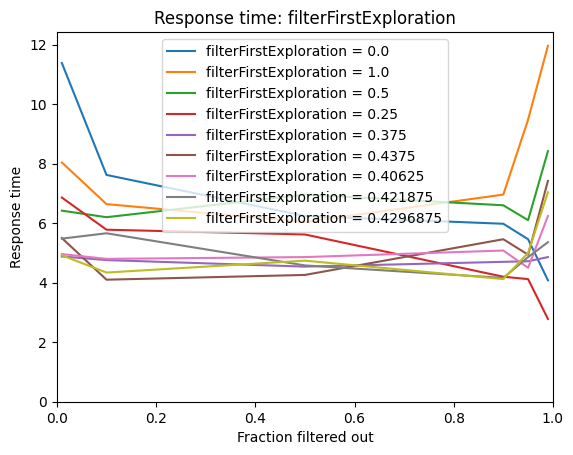

In [71]:
# Plot response time for different filterFirstExploration values
for ffe, benchmark, _ in benchmarks:
    plt.plot(
        optimizer.buckets_to_filtered_out(benchmark.x),
        benchmark.y,
        label=f"filterFirstExploration = {ffe}",
    )

plt.title("Response time: filterFirstExploration")
plt.xlabel("Fraction filtered out")
plt.ylabel("Response time")
plt.legend()
axs = plt.gca()
axs.set_xlim(xmin=0, xmax=1)
axs.set_ylim(ymin=0)
plt.show()

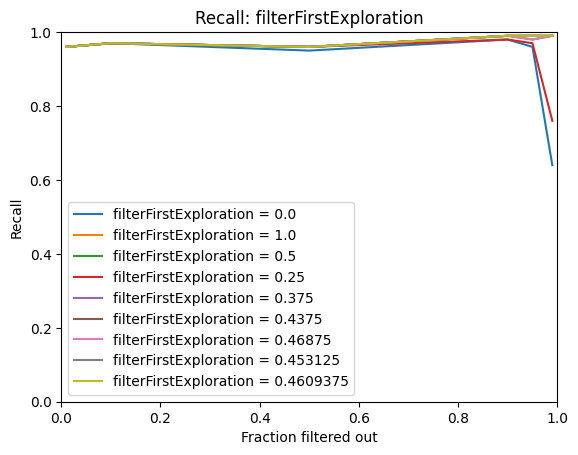

In [22]:
# Plot recall for different filterFirstExploration values
for ffe, _, recall in benchmarks:
    plt.plot(
        optimizer.buckets_to_filtered_out(recall.x),
        recall.y,
        label=f"filterFirstExploration = {ffe}",
    )

plt.title("Recall: filterFirstExploration")
plt.xlabel("Fraction filtered out")
plt.ylabel("Recall")
plt.legend()
axs = plt.gca()
axs.set_xlim(xmin=0, xmax=1)
axs.set_ylim(ymin=0, ymax=1)
plt.show()

### Step 3: Optimize filterFirstThreshold

This parameter determines when to use the filter-first strategy based on the fraction of documents filtered out.

In [72]:
print("Determining suggestion for filterFirstThreshold")
hnsw_parameters = {
    "timeout": "20s",
    "ranking.matching.approximateThreshold": 0.00,
    "ranking.matching.filterFirstThreshold": 0.00,
}
benchmark_hnsw = optimizer.benchmark(**hnsw_parameters)

filter_first_parameters = {
    "timeout": "20s",
    "ranking.matching.approximateThreshold": 0.00,
    "ranking.matching.filterFirstThreshold": 1.00,
    "ranking.matching.filterFirstExploration": filter_first_exploration,
}
benchmark_filter_first = optimizer.benchmark(**filter_first_parameters)

Determining suggestion for filterFirstThreshold
  Benchmarking: 100.0%
  Benchmarking: 100.0%


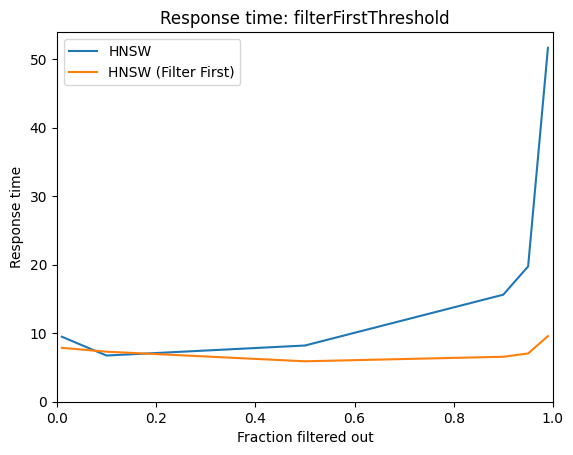

In [73]:
# Plot response time comparison
plt.plot(
    optimizer.buckets_to_filtered_out(benchmark_hnsw.x), benchmark_hnsw.y, label="HNSW"
)
plt.plot(
    optimizer.buckets_to_filtered_out(benchmark_filter_first.x),
    benchmark_filter_first.y,
    label="HNSW (Filter First)",
)

plt.title("Response time: filterFirstThreshold")
plt.xlabel("Fraction filtered out")
plt.ylabel("Response time")
plt.legend()
axs = plt.gca()
axs.set_xlim(xmin=0, xmax=1)
axs.set_ylim(ymin=0)
plt.show()

In [74]:
filter_first_threshold = optimizer.suggest_filter_first_threshold(
    benchmark_hnsw, benchmark_filter_first
)
print(f"  filterFirstThreshold: {round(filter_first_threshold, 3)}")

  filterFirstThreshold: 1.0


### Step 4: Optimize approximateThreshold

This parameter determines when to use exact search vs approximate search.

In [26]:
print("Determining suggestion for approximateThreshold")
exact_parameters = {"timeout": "20s", "ranking.matching.approximateThreshold": 1.00}
benchmark_exact = optimizer.benchmark(**exact_parameters)

filter_first_parameters2 = {
    "timeout": "20s",
    "ranking.matching.approximateThreshold": 0.00,
    "ranking.matching.filterFirstThreshold": filter_first_threshold,
    "ranking.matching.filterFirstExploration": filter_first_exploration,
}
benchmark_filter_first2 = optimizer.benchmark(**filter_first_parameters2)

Determining suggestion for approximateThreshold
  Benchmarking: 100.0%
  Benchmarking: 100.0%


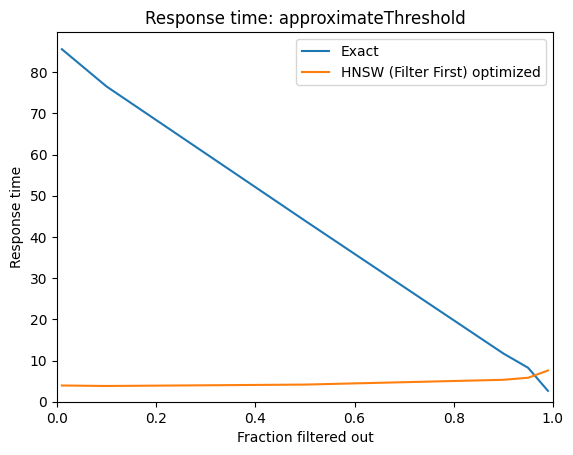

In [27]:
# Plot response time comparison
plt.plot(
    optimizer.buckets_to_filtered_out(benchmark_exact.x),
    benchmark_exact.y,
    label="Exact",
)
plt.plot(
    optimizer.buckets_to_filtered_out(benchmark_filter_first2.x),
    benchmark_filter_first2.y,
    label="HNSW (Filter First) optimized",
)

plt.title("Response time: approximateThreshold")
plt.xlabel("Fraction filtered out")
plt.ylabel("Response time")
plt.legend()
axs = plt.gca()
axs.set_xlim(xmin=0, xmax=1)
axs.set_ylim(ymin=0)
plt.show()

In [28]:
approximate_threshold = optimizer.suggest_approximate_threshold(
    benchmark_exact, benchmark_filter_first2
)
print(f"  approximateThreshold: {round(approximate_threshold, 3)}")

  approximateThreshold: 0.04


### Step 5: Optimize postFilterThreshold

This parameter determines when to use post-filtering vs other strategies.

In [29]:
print("Determining suggestion for postFilterThreshold")
post_filtering_parameters = {
    "timeout": "20s",
    "ranking.matching.postFilterThreshold": 0.00,
    "ranking.matching.approximateThreshold": 0.00,
}
benchmark_post_filtering = optimizer.benchmark(**post_filtering_parameters)

filter_first_parameters3 = {
    "timeout": "20s",
    "ranking.matching.approximateThreshold": approximate_threshold,
    "ranking.matching.filterFirstThreshold": filter_first_threshold,
    "ranking.matching.filterFirstExploration": filter_first_exploration,
}
benchmark_filter_first3 = optimizer.benchmark(**filter_first_parameters3)

Determining suggestion for postFilterThreshold
  Benchmarking: 100.0%
  Benchmarking: 100.0%


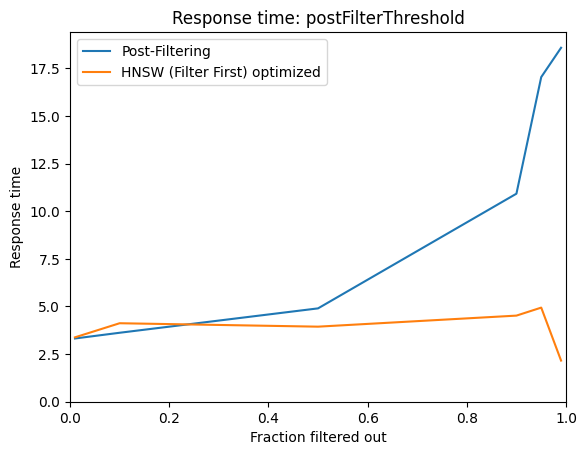

In [30]:
# Plot response time comparison
plt.plot(
    optimizer.buckets_to_filtered_out(benchmark_post_filtering.x),
    benchmark_post_filtering.y,
    label="Post-Filtering",
)
plt.plot(
    optimizer.buckets_to_filtered_out(benchmark_filter_first3.x),
    benchmark_filter_first3.y,
    label="HNSW (Filter First) optimized",
)

plt.title("Response time: postFilterThreshold")
plt.xlabel("Fraction filtered out")
plt.ylabel("Response time")
plt.legend()
axs = plt.gca()
axs.set_xlim(xmin=0, xmax=1)
axs.set_ylim(ymin=0)
plt.show()

In [43]:
recall_post_filtering = optimizer.compute_average_recalls(**post_filtering_parameters)
recall_filter_first3 = optimizer.compute_average_recalls(**filter_first_parameters3)
print(recall_post_filtering.x, recall_post_filtering.y)

  Computing recall: 100.0%
  Computing recall: 100.0%
[2, 20, 100, 180, 190, 198] [0.9600000000000002, 0.97, 0.99, 1.0, 1.0, 1.0]


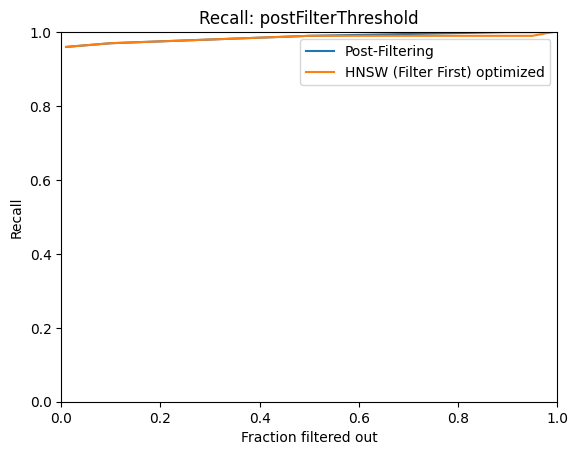

In [32]:
# Plot recall comparison
plt.plot(
    optimizer.buckets_to_filtered_out(recall_post_filtering.x),
    recall_post_filtering.y,
    label="Post-Filtering",
)
plt.plot(
    optimizer.buckets_to_filtered_out(recall_filter_first3.x),
    recall_filter_first3.y,
    label="HNSW (Filter First) optimized",
)

plt.title("Recall: postFilterThreshold")
plt.xlabel("Fraction filtered out")
plt.ylabel("Recall")
plt.legend()
axs = plt.gca()
axs.set_xlim(xmin=0, xmax=1)
axs.set_ylim(ymin=0, ymax=1)
plt.show()

In [33]:
post_filter_threshold = optimizer.suggest_post_filter_threshold(
    benchmark_post_filtering,
    recall_post_filtering,
    benchmark_filter_first3,
    recall_filter_first3,
)
print(f"  postFilterThreshold: {round(post_filter_threshold, 3)}")

  postFilterThreshold: 0.76


### Step 6: Compare Current vs Suggested Settings

Finally, let's compare the performance of the current settings with the optimized suggested settings.

In [34]:
print("Comparing current to suggested settings")

suggested_parameters = {
    "timeout": "20s",
    "ranking.matching.approximateThreshold": approximate_threshold,
    "ranking.matching.filterFirstThreshold": filter_first_threshold,
    "ranking.matching.filterFirstExploration": filter_first_exploration,
    "ranking.matching.postFilterThreshold": post_filter_threshold,
}

benchmark_current = optimizer.benchmark()
benchmark_suggested = optimizer.benchmark(**suggested_parameters)

Comparing current to suggested settings
  Benchmarking: 100.0%
  Benchmarking: 100.0%


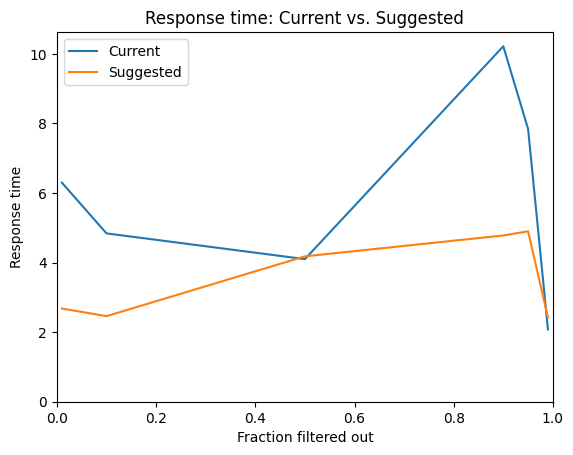

In [35]:
# Plot response time comparison
plt.plot(
    optimizer.buckets_to_filtered_out(benchmark_current.x),
    benchmark_current.y,
    label="Current",
)
plt.plot(
    optimizer.buckets_to_filtered_out(benchmark_suggested.x),
    benchmark_suggested.y,
    label="Suggested",
)

plt.title("Response time: Current vs. Suggested")
plt.xlabel("Fraction filtered out")
plt.ylabel("Response time")
plt.legend()
axs = plt.gca()
axs.set_xlim(xmin=0, xmax=1)
axs.set_ylim(ymin=0)
plt.show()

In [41]:
recall_current = optimizer.compute_average_recalls()
recall_optimized = optimizer.compute_average_recalls(**suggested_parameters)
print("Recall Current vs. Suggested")
print("Current:")
print(recall_current.x, recall_current.y)
print("Suggested:")
print(recall_optimized.x, recall_optimized.y)

  Computing recall: 100.0%
  Computing recall: 100.0%
Recall Current vs. Suggested
Current:
[2, 20, 100, 180, 190, 198] [0.9600000000000002, 0.97, 0.99, 1.0, 1.0, 1.0]
Suggested:
[2, 20, 100, 180, 190, 198] [0.9600000000000002, 0.97, 0.99, 0.99, 0.99, 1.0]


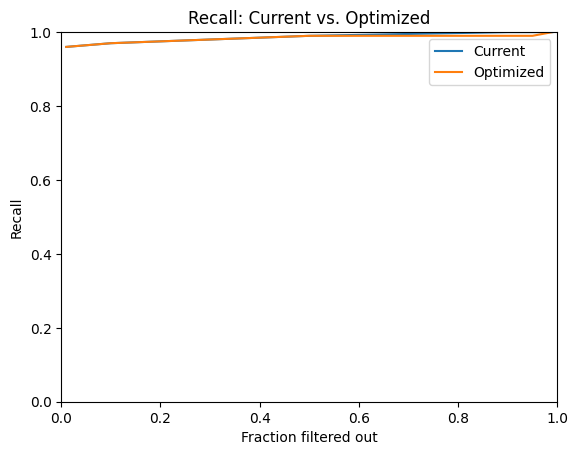

In [37]:
# Plot recall comparison
plt.plot(
    optimizer.buckets_to_filtered_out(recall_current.x),
    recall_current.y,
    label="Current",
)
plt.plot(
    optimizer.buckets_to_filtered_out(recall_optimized.x),
    recall_optimized.y,
    label="Optimized",
)

plt.title("Recall: Current vs. Optimized")
plt.xlabel("Fraction filtered out")
plt.ylabel("Recall")
plt.legend()
axs = plt.gca()
axs.set_xlim(xmin=0, xmax=1)
axs.set_ylim(ymin=0, ymax=1)
plt.show()

## Summary

The optimization process has determined the following suggested parameters:

- **filterFirstExploration**: Controls exploration when using filter-first strategy
- **filterFirstThreshold**: Determines when to use filter-first based on fraction filtered
- **approximateThreshold**: Determines when to use exact vs approximate search
- **postFilterThreshold**: Determines when to use post-filtering strategy

These optimized parameters should provide better performance while maintaining recall quality.